In [58]:
import pandas as pd
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [59]:
df = pd.read_csv('Dataset/umist_faces.csv')


In [60]:
df.shape

(575, 10305)

In [61]:
df.head()

label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0    1a    233.0    234.0    234.0    233.0    234.0    232.0    232.0   
1    1a    234.0    234.0    234.0    234.0    233.0    232.0    202.0   
2    1a    234.0    234.0    234.0    234.0    233.0    230.0    225.0   
3    1a    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
4    1a    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_7  pixel_8  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    168.0     99.0  ...        157.0        154.0        151.0        147.0   
1     98.0     79.0  ...        158.0        154.0        150.0        147.0   
2    109.0     85.0  ...        180.0        174.0        168.0        164.0   
3    232.0    229.0  ...        174.0        168.0        162.0        157.0   
4    234.0    229.0  ...        186.0        176.0        170.0        164.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        143.0        140.0        141.0        141.0        140.0   
1        141.0        140.0        137.0        138.0        137.0   
2        157.0        152.0        151.0        148.0        145.0   
3        155.0        150.0        144.0        144.0        142.0   
4        162.0        157.0        152.0        150.0        148.0   

   pixel_10303  
0        136.0  
1        137.0  
2        145.0  
3        143.0  
4        148.0  

[5 rows x 10305 columns]

In [62]:
# # df.duplicated()
# # Custom funciton to check for duplicates
# counter = 0
# # If the vaues are duplicated then the label is also gonna be same
# for i in range(len(df)):
#     for j in range(i+1, len(df)):
#         # Check for the same image if the labels are same
#         if(df.iloc[i, 0] == df.iloc[j, 0]):
#             # Check if the rows are same
#             if(df.iloc[i, 1:].equals(df.iloc[j, 1:])):
#                 print("Duplicate found")
#                 print(df.iloc[i, 0])
#                 print(df.iloc[j, 0])
#                 print("Row 1: ", df.iloc[i, 1:])
#                 print("Row 2: ", df.iloc[j, 1:])
#                 counter += 1
#                 print("\n\n")
                
# print("Total duplicates found: ", counter)
        

In [63]:
# Dropping the duplicates
df = df.drop_duplicates()
df.shape

(565, 10305)

In [64]:
X = df.drop('label', axis=1).values
y = df['label']

In [65]:
# Check if there are any duplicates
df.duplicated().sum()


0

In [66]:
# Reshape images (assuming 112x92 image size)
image_size = (112, 92)
X = X.reshape(-1, *image_size)

In [67]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


In [68]:
from sklearn.model_selection import train_test_split
# Split data into training, testing, and validation sets using stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

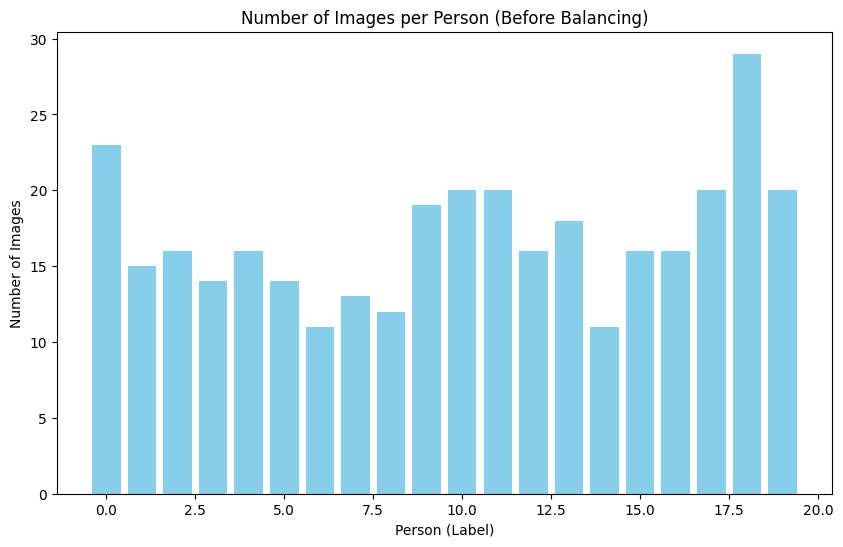

Balanced dataset shape: (960, 112, 92, 1), (960,)


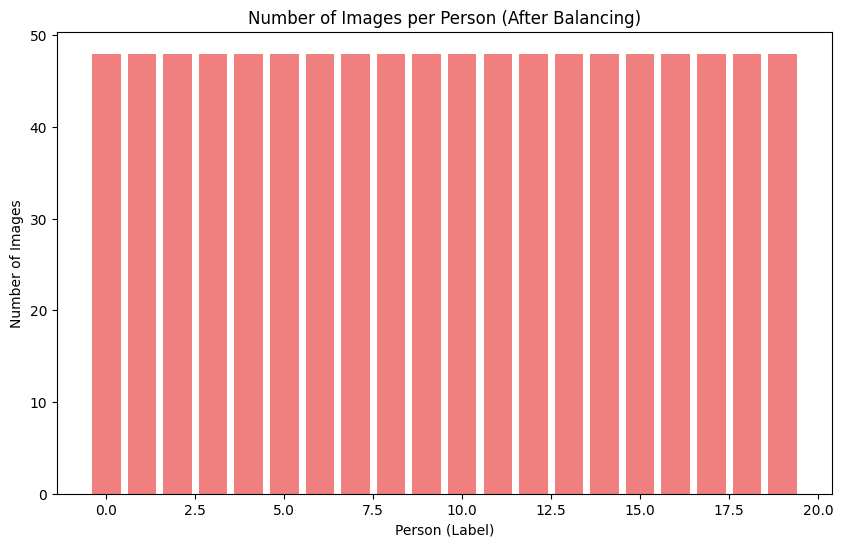

In [69]:
# Balance the training dataset using ImageDataGenerator
TARGET_IMAGES_PER_PERSON = 48

# Split the dataset by label
unique_labels = np.unique(y_train)
label_to_images = {label: X_train[y_train == label] for label in unique_labels}

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.20,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Before balancing: plot the number of images per person
initial_counts = [np.sum(y_train == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, initial_counts, color='skyblue')
plt.title('Number of Images per Person (Before Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

balanced_X = []
balanced_y = []

for label, images in label_to_images.items():
    num_images = images.shape[0]
    if num_images < TARGET_IMAGES_PER_PERSON:
        # Add channel dimension to images (assuming grayscale images)
        images = np.expand_dims(images, axis=-1)  # Shape becomes (num_images, height, width, 1)
        
        # Generate augmented images
        augmented_images = []
        for x in datagen.flow(images, batch_size=1, seed=42):
            augmented_images.append(x[0])  # x is a batch, take the first image
            if len(augmented_images) + num_images >= TARGET_IMAGES_PER_PERSON:
                break
        combined_images = np.concatenate([images, np.array(augmented_images)])
    else:
        # Randomly select TARGET_IMAGES_PER_PERSON images
        combined_images = images[np.random.choice(num_images, TARGET_IMAGES_PER_PERSON, replace=False)]

    balanced_X.extend(combined_images)
    balanced_y.extend([label] * TARGET_IMAGES_PER_PERSON)

# Convert balanced dataset to numpy arrays
balanced_X = np.array(balanced_X)
balanced_y = np.array(balanced_y)

print(f"Balanced dataset shape: {balanced_X.shape}, {balanced_y.shape}")

# After balancing: plot the number of images per person
balanced_counts = [np.sum(balanced_y == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, balanced_counts, color='lightcoral')
plt.title('Number of Images per Person (After Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

// Preprocessing Steps

In [70]:
X_train = balanced_X.reshape(balanced_X.shape[0], -1)
y_train = balanced_y

In [71]:
X_train

array([[234.        , 235.        , 234.        , ..., 190.        ,
        191.        , 190.        ],
       [234.        , 234.        , 234.        , ..., 191.        ,
        192.        , 193.        ],
       [234.        , 234.        , 234.        , ..., 166.        ,
        164.        , 163.        ],
       ...,
       [ 38.        ,  38.        ,  38.        , ...,  96.81337738,
         95.34307098,  97.25445557],
       [ 22.        ,  22.        ,  22.        , ...,  76.63969421,
         78.00157166,  80.56132507],
       [164.        , 164.        , 164.        , ...,  90.55519104,
         85.24390411,  78.02172852]])

In [72]:
# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [73]:
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


In [84]:
# PCA

# Perform PCA on the training set
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

X_train_pca.shape

(960, 400)

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense

def create_model(n_hidden_layer_1, n_bottleneck, n_hidden_layer_2, learning_rate, regularizer):
    model = models.Sequential()
    model.add(Input(shape=(400,)))
    model.add(Dense(n_hidden_layer_1, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(regularizer)))
    model.add(Dense(n_bottleneck, activation='leaky_relu'))
    model.add(Dense(n_hidden_layer_2, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(regularizer)))
    model.add(Dense(400, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

In [87]:
# Hyperparameters
n_hidden_layer_1 = [108, 78, 64]
n_bottleneck = [64, 32, 16]
n_hidden_layer_2 = [108, 78, 64]
learning_rates = [0.001, 0.01]
regularizers = [1e-4, 1e-3, 1e-2,0.1]

# Grid search
# K-fold cross-validation
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
best_score = 0
best_params = None

for n_units_1 in n_hidden_layer_1:
    for n_bottleneck_units in n_bottleneck:
        for n_units_2 in n_hidden_layer_2:
            for lr in learning_rates:
                for reg in regularizers:
                    fold_scores = []
                    for train_index, val_index in kf.split(X_train_pca):
                        X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
                        y_train_fold, y_val_fold = X_train_pca[train_index], X_train_pca[val_index]  # Autoencoder uses input as output
                        
                        model = create_model(n_units_1, n_bottleneck_units, n_units_2, lr, reg)
                        model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, verbose=0)
                        score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
                        fold_scores.append(score)  # Loss
                        
                    avg_score = np.mean(fold_scores)
                    if avg_score < best_score or best_score == 0:  # Lower loss is better
                        best_score = avg_score
                        best_params = {'n_units_1': n_units_1, 'n_bottleneck': n_bottleneck_units, 'n_units_2': n_units_2, 'learning_rate': lr, 'regularizer': reg}

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Loss: {best_score}")


ValueError: Dimensions must be equal, but are 400 and 176 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, sequential_5_1/dense_16_1/Sigmoid)' with input shapes: [32,400], [32,176].

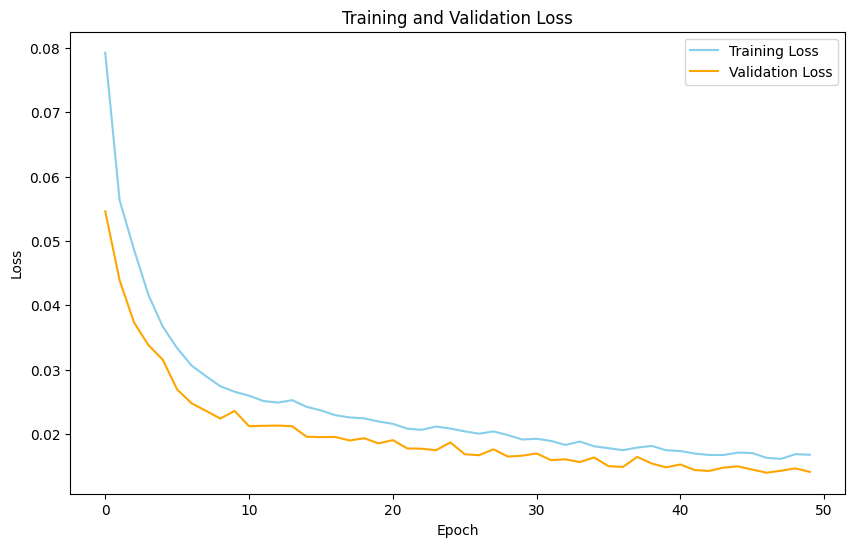

In [76]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='skyblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [77]:
# Encode the data using the bottleneck layer
encoder = Sequential(autoencoder.layers[:2])  # Extract the encoder part
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Best n_components: 33, Best Silhouette Score: 0.16251103579998016


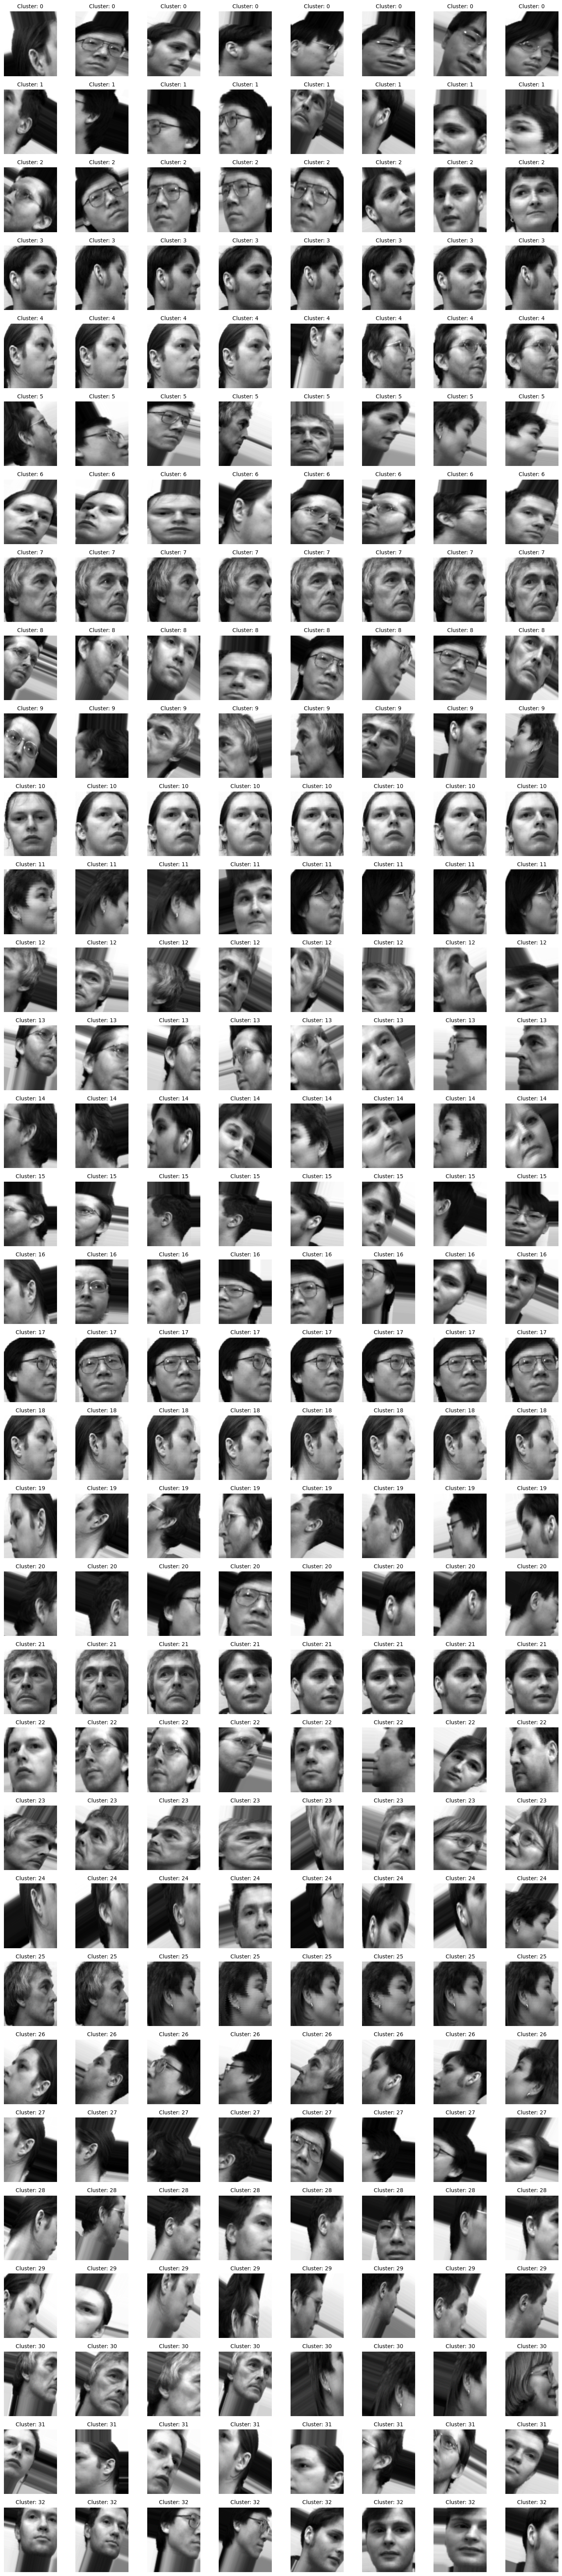

In [83]:
# Implementing the GMM:

from sklearn.mixture import GaussianMixture

best_n_components = None
best_score = -1  # For silhouette, higher is better

for n_components in range(20, 40):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    y_gmm = gmm.fit_predict(X_train_encoded)
    
    # Compute the silhouette score
    score = silhouette_score(X_train_encoded, y_gmm)
    if score > best_score:
        best_n_components = n_components
        best_score = score

print(f"Best n_components: {best_n_components}, Best Silhouette Score: {best_score}")

gmm = GaussianMixture(n_components=best_n_components, random_state=0)
y_gmm = gmm.fit_predict(X_train_encoded)

y_gmm_unique = np.unique(y_gmm)
plt.figure(figsize=(15, len(y_gmm_unique) * 2))  # Adjust the figure size as needed

for i, cluster in enumerate(y_gmm_unique):
    indices = np.where(y_gmm == cluster)[0]
    for j, index in enumerate(indices):
        if j >= 8:  # Limit to 8 images per cluster for better visualization
            break
        plt.subplot(len(y_gmm_unique), 8, i * 8 + j + 1)
        plt.imshow(np.reshape(X_train[index], (112, 92)), cmap=plt.cm.gray)
        plt.title('Cluster: ' + str(cluster), fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Combine PCA-reduced features with K-Means cluster assignments
# Ensure consistent one-hot encoding for cluster labels
num_clusters = len(np.unique(y_gmm))  # Number of clusters from KMeans
clusters_one_hot = to_categorical(y_gmm, num_clusters)
# Augment datasets with one-hot encoded clusters
X_train_augmented = np.hstack((X_train_encoded, clusters_one_hot))
X_val_clusters = to_categorical(gmm.predict(X_val_encoded), num_clusters)
X_val_augmented = np.hstack((X_val_encoded, X_val_clusters))
X_test_clusters = to_categorical(gmm.predict(X_test_encoded), num_clusters)
X_test_augmented = np.hstack((X_test_encoded, X_test_clusters))

# Debugging: Check augmented dataset shapes
print("Augmented Shapes:", X_train_augmented.shape, X_val_augmented.shape, X_test_augmented.shape)

Augmented Shapes: (960, 423) (113, 423) (113, 423)


In [53]:
# One-hot encode labels for classification
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [54]:
# Check the shape of X_train_augmented
input_shape = X_train_augmented.shape[1]

# Build the neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(y_train_one_hot.shape[1], activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_augmented, y_train_one_hot,
    validation_data=(X_val_augmented, y_val_one_hot),
    epochs=50,
    batch_size=32
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0601 - loss: 7.3932 - val_accuracy: 0.4248 - val_loss: 5.7797
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1439 - loss: 5.8377 - val_accuracy: 0.6372 - val_loss: 4.6413
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2596 - loss: 4.8716 - val_accuracy: 0.7434 - val_loss: 3.6648
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3347 - loss: 4.1796 - val_accuracy: 0.8850 - val_loss: 2.9323
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4428 - loss: 3.5653 - val_accuracy: 0.9115 - val_loss: 2.3982
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4928 - loss: 3.2093 - val_accuracy: 0.9292 - val_loss: 2.0839
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4975 - loss: 3.0185 - val_accuracy: 0.9381 - val_loss: 1.8152
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5343 - loss: 2.7490 - val_accuracy: 0.9204 - val_loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 0.6637 
Test Loss: 0.6637142300605774
Test Accuracy: 0.991150438785553


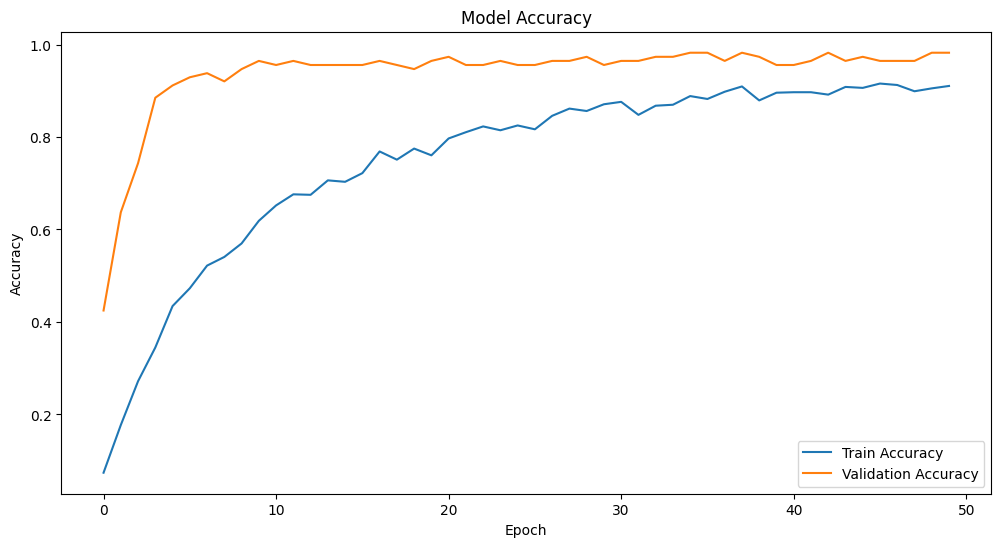

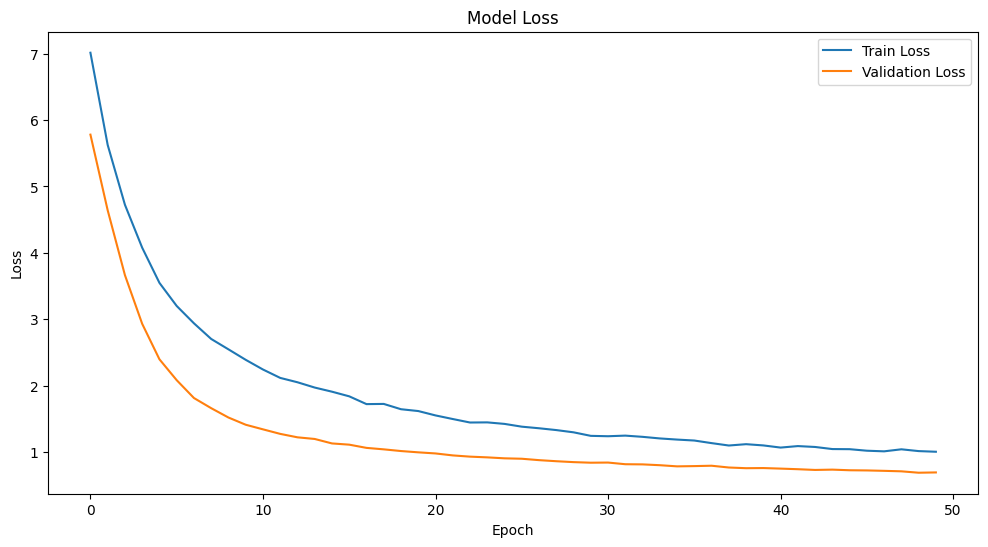

In [55]:
# Evaluate the model
results = model.evaluate(X_test_augmented, y_test_one_hot)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


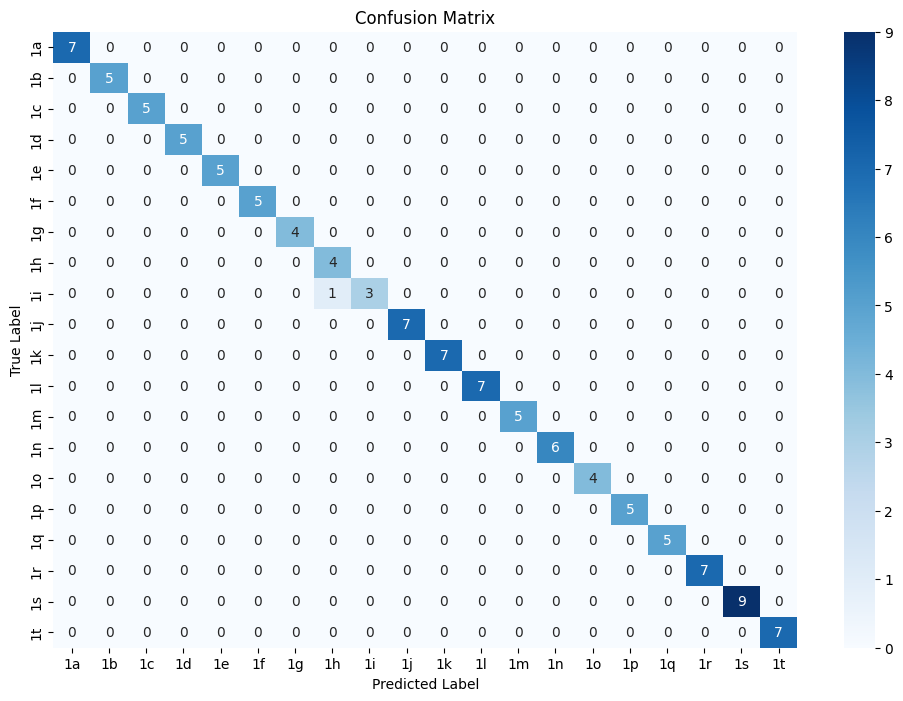

In [56]:
# Predictions
y_pred = model.predict(X_test_augmented)
y_pred = np.argmax(y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


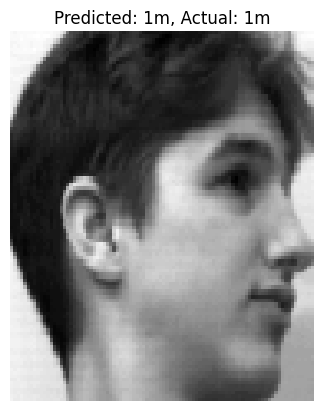

In [57]:
# Lets try it with images to see how well it works
# Select a random test image
random_index = np.random.randint(1, X_test.shape[0])
random_image = X_test[random_index]

# Reshape the image to (1, 112, 92) to match the model input dimensions
random_image = random_image.reshape(1, -1)

# Perform PCA on the image
random_image_pca = pca.transform(random_image)

# Perform KMeans clustering on the PCA features
random_image_cluster = gmm.predict(random_image_pca)

# One-hot encode the cluster
random_image_cluster_one_hot = to_categorical(random_image_cluster, num_clusters)

# Combine PCA features with cluster assignment
random_image_augmented = np.hstack((random_image_pca, random_image_cluster_one_hot))

# Make a prediction
prediction = model.predict(random_image_augmented)
predicted_label = np.argmax(prediction)
actual_label = y_test[random_index]

# Display the image and prediction and actual label
plt.imshow(np.reshape(random_image, (112, 92)), cmap='gray')
plt.title(f'Predicted: {le.inverse_transform([predicted_label])[0]}, Actual: {le.inverse_transform([actual_label])[0]}')
plt.axis('off')
plt.show()
